# Temperature forcasting - daily temperature in Delhi, India.

- **Dataset**: 
    - Available at: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/
    - Historical temp data from 2013 to 2017`

In [1]:
# import required libraries
import pickle
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.offline as py
py.init_notebook_mode()
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('data/DailyDelhiClimateTrain.csv')
df.shape

(1462, 5)

In [3]:
df.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [4]:
df.tail()

date   meantemp    humidity  wind_speed  meanpressure
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000

- The data consists of daily temperature + other readings from 1st January 2013 to 1st January 2017 in the city of Delhi, India

## EDA and data pre-processing

- Check and fix dtypes
- CHeck and fix null values
- Stats for numerical columns
- Subset data for use with prophet
- Visualize

In [5]:
# Check and fix dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [6]:
# Change dtype for date
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [7]:
# Check for Null values
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

- no null values

In [8]:
# stats for numerical columns
df.describe()

date     meantemp     humidity   wind_speed  \
count                 1462  1462.000000  1462.000000  1462.000000   
mean   2015-01-01 12:00:00    25.495521    60.771702     6.802209   
min    2013-01-01 00:00:00     6.000000    13.428571     0.000000   
25%    2014-01-01 06:00:00    18.857143    50.375000     3.475000   
50%    2015-01-01 12:00:00    27.714286    62.625000     6.221667   
75%    2016-01-01 18:00:00    31.305804    72.218750     9.238235   
max    2017-01-01 00:00:00    38.714286   100.000000    42.220000   
std                    NaN     7.348103    16.769652     4.561602   

       meanpressure  
count   1462.000000  
mean    1011.104548  
min       -3.041667  
25%     1001.580357  
50%     1008.563492  
75%     1014.944901  
max     7679.333333  
std      180.231668

In [9]:
# For use with prophet, update a dataframe with column names to 'ds' and 'y'
df = df.rename(columns={'date':'ds', 'meantemp':'y'})
df.head()

ds          y   humidity  wind_speed  meanpressure
0 2013-01-01  10.000000  84.500000    0.000000   1015.666667
1 2013-01-02   7.400000  92.000000    2.980000   1017.800000
2 2013-01-03   7.166667  87.000000    4.633333   1018.666667
3 2013-01-04   8.666667  71.333333    1.233333   1017.166667
4 2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [10]:
# Visualize the data
fig = px.line(df, x='ds', y='y')
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Temperature (°C)")
fig.show()

In [11]:
fig = px.scatter(df, x='ds', y='y')
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Temperature (°C)")
fig.show()

### Decomposition

A very common analysis technique for data recorded over time (time series data) is *decomposition*.
The average temperature data is *composed* of a few patterns:

- **trend**: as the years go by is it getting systematically hotter or colder?
- **seasonality**: it is always hotter in June than it is in March
- **residual**: any variation in the data not captured by trend or seasonal effect


In [12]:
df_decompose= df.copy()
df_decompose.set_index('ds', inplace=True)

In [13]:
df_decompose

y    humidity  wind_speed  meanpressure
ds                                                         
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

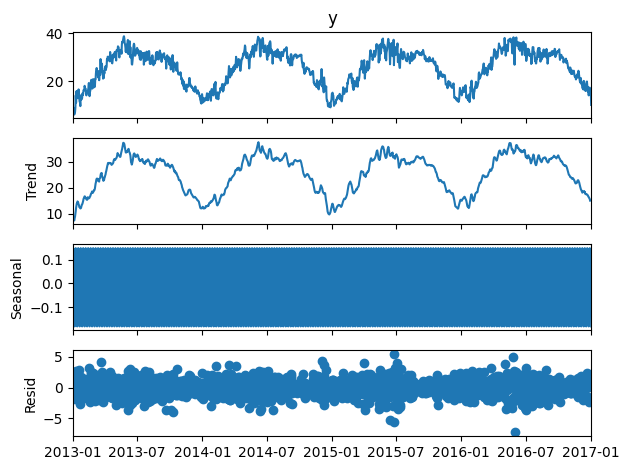

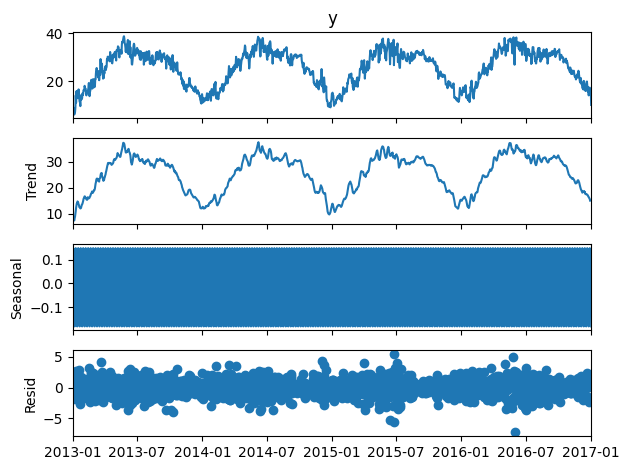

In [14]:
# Decomposition
df_decomposition_result = seasonal_decompose(df_decompose['y'], model = 'additive')
df_decomposition_result.plot()

##  Forecasting Model

- SARIMA -  Seasonal Autoregressive Integrated Moving Average
    - Create and train basic prophet Model
    - predict
    - visualize
    - Evaluate
- Basic prophet model
    - Create and train basic prophet Model
    - predict
    - visualize
    - Evaluate
- prophet model with additional regressors
    - Create and train prophet Model with additional regressors
    - predict
    - visualize
    - Evaluate

### SARIMA -  Seasonal Autoregressive Integrated Moving Average

Best SARIMA Model Order: (1, 1, 1)
Best Seasonal Order: (0, 0, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90045D+00    |proj g|=  2.29983D-02

At iterate    5    f=  1.89363D+00    |proj g|=  8.57851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.797D-06   1.893D+00
  F =   1.8934604033819256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


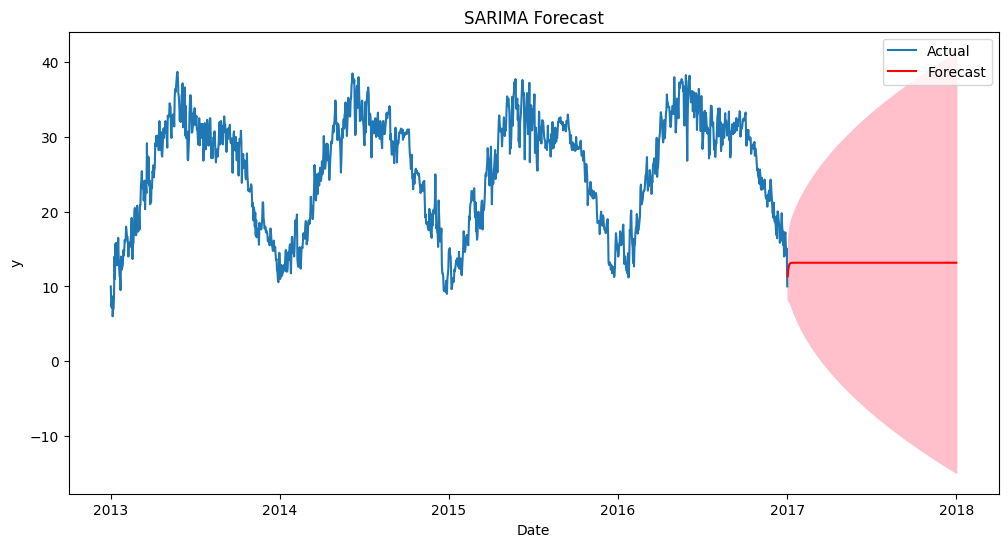

In [15]:
# Define SARIMA hyperparameters and possible values
p_values = range(0, 2)  # Limit the range
d_values = range(0, 2)  # Limit the range
q_values = range(0, 2)  # Limit the range
P_values = range(0, 2)  # Limit the range
D_values = range(0, 2)  # Limit the range
Q_values = range(0, 2)  # Limit the range
s = 7  # Seasonal period (assuming daily data, 7 days in a week)

# Initialize variables to store best model and parameters
best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Perform grid search to find the best SARIMA model
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(df_decompose['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit(disp=False)
        aic = results.aic

        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, s)

    except:
        continue

# Print the best SARIMA model parameters
print(f"Best SARIMA Model Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")

# Create and fit the best SARIMA model
best_model = SARIMAX(df_decompose['y'], order=best_order, seasonal_order=best_seasonal_order)
best_results = best_model.fit()

# Make forecasts
forecast_steps = 365  # Change this value as needed
forecast = best_results.get_forecast(steps=forecast_steps)

# Get forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the original data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_decompose['y'], label='Actual')
plt.plot(forecasted_values, label='Forecast', color='red')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink')
plt.legend()
plt.xlabel('Date')
plt.ylabel('y')
plt.title('SARIMA Forecast')
plt.show()


### Basic prophet model

In [16]:
# Basic prophet model
base_model = Prophet()
base_model.fit(df)

00:36:56 - cmdstanpy - INFO - Chain [1] start processing
00:36:56 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Create a future dataframe
future = base_model.make_future_dataframe(periods=365)
future.tail()

ds
1822 2017-12-28
1823 2017-12-29
1824 2017-12-30
1825 2017-12-31
1826 2018-01-01

In [18]:
future.head()

ds
0 2013-01-01
1 2013-01-02
2 2013-01-03
3 2013-01-04
4 2013-01-05

- includes original date range too

In [19]:
# Make predictions for the future dates
forecast = base_model.predict(future)
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1822 2017-12-28  28.558458   13.284755   18.407733    28.016622    29.133990   
1823 2017-12-29  28.561339   13.015626   18.340177    28.017528    29.139409   
1824 2017-12-30  28.564219   13.112595   18.350470    28.018523    29.145417   
1825 2017-12-31  28.567099   12.602234   18.135251    28.020132    29.152667   
1826 2018-01-01  28.569980   12.949393   18.468254    28.021015    29.158548   

      additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
1822      -12.794668            -12.794668            -12.794668  0.067150   
1823      -12.894379            -12.894379            -12.894379  0.027528   
1824      -13.029319            -13.029319            -13.029319 -0.069127   
1825      -13.172926            -13.172926            -13.172926 -0.195063   
1826      -12.987132            -12.987132            -12.987132 -0.010773   

      weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
1822      0.067150      0.067150 -12.861818    -12.861818    -12.861818   
1823      0.027528      0.027528 -12.921906    -12.921906    -12.921906   
1824     -0.069127     -0.069127 -12.960192    -12.960192    -12.960192   
1825     -0.195063     -0.195063 -12.977863    -12.977863    -12.977863   
1826     -0.010773     -0.010773 -12.976359    -12.976359    -12.976359   

      multiplicative_terms  multiplicative_terms_lower  \
1822                   0.0                         0.0   
1823                   0.0                         0.0   
1824                   0.0                         0.0   
1825                   0.0                         0.0   
1826                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1822                         0.0  15.763790  
1823                         0.0  15.666960  
1824                         0.0  15.534900  
1825                         0.0  15.394173  
1826                         0.0  15.582847

In [20]:
# temp prediction related columns only
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1822 2017-12-28  15.763790   13.284755   18.407733
1823 2017-12-29  15.666960   13.015626   18.340177
1824 2017-12-30  15.534900   13.112595   18.350470
1825 2017-12-31  15.394173   12.602234   18.135251
1826 2018-01-01  15.582847   12.949393   18.468254

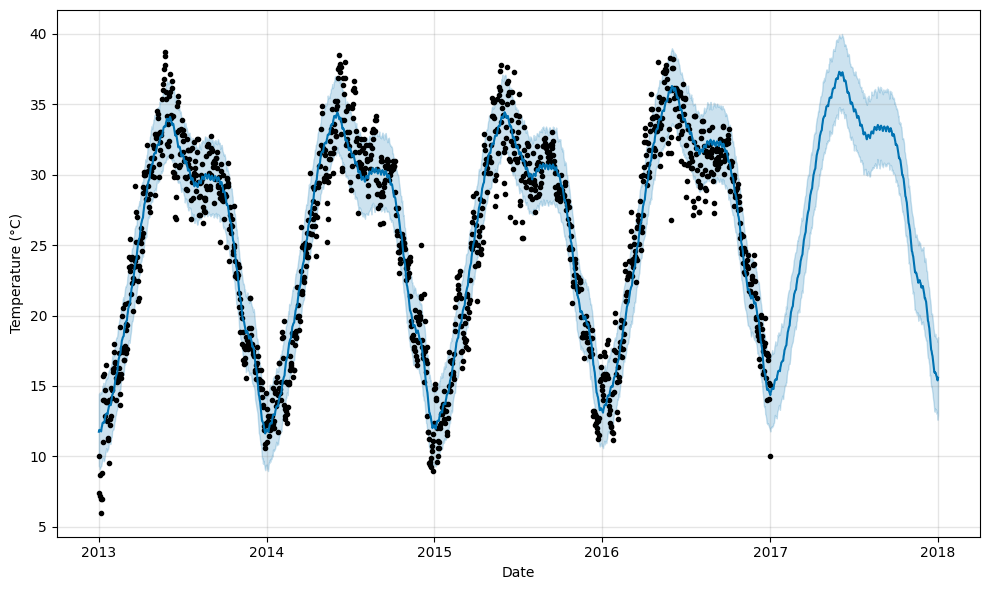

In [21]:
# Visualize the predictions
base_model.plot(forecast)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

- The plot shows the actual temperature data as black dots, the predicted values as a blue line, and the prediction intervals as shaded blue areas. 
- The model captures the seasonality pattern and the trend in the data.

### Evaluate/Compare with test data available

In [22]:
# Load the test data
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.rename(columns={'date':'ds', 'meantemp':'y'})

In [23]:
# Extract the predicted values from the forecast DataFrame for the matching dates
matching_dates = forecast['ds'].isin(df_test['ds'])
predicted_values = forecast.loc[matching_dates, 'yhat'].values

# Extract the actual values from df_test for the matching dates
actual_values = df_test.loc[df_test['ds'].isin(forecast['ds']), 'y'].values

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
# rmse = np.sqrt(mse)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 2.187801761181909
Mean Squared Error (MSE): 7.094828632630564
Root Mean Squared Error (RMSE): 2.6636119523366317


In [24]:
# Create a DataFrame with three columns: Matching Dates, Predicted Values, and Actual Values
result_df = pd.DataFrame({'Matching Dates': forecast.loc[matching_dates, 'ds'].values,
                          'Predicted Values': predicted_values,
                          'Actual Values': actual_values})

# Display the result DataFrame
print(result_df)

    Matching Dates  Predicted Values  Actual Values
0       2017-01-01         14.350417      15.913043
1       2017-01-02         14.560721      18.500000
2       2017-01-03         14.646778      17.111111
3       2017-01-04         14.813565      18.700000
4       2017-01-05         14.800330      18.388889
..             ...               ...            ...
109     2017-04-20         32.872454      34.500000
110     2017-04-21         33.016232      34.250000
111     2017-04-22         33.097831      32.900000
112     2017-04-23         33.144384      32.875000
113     2017-04-24         33.494851      32.000000

[114 rows x 3 columns]


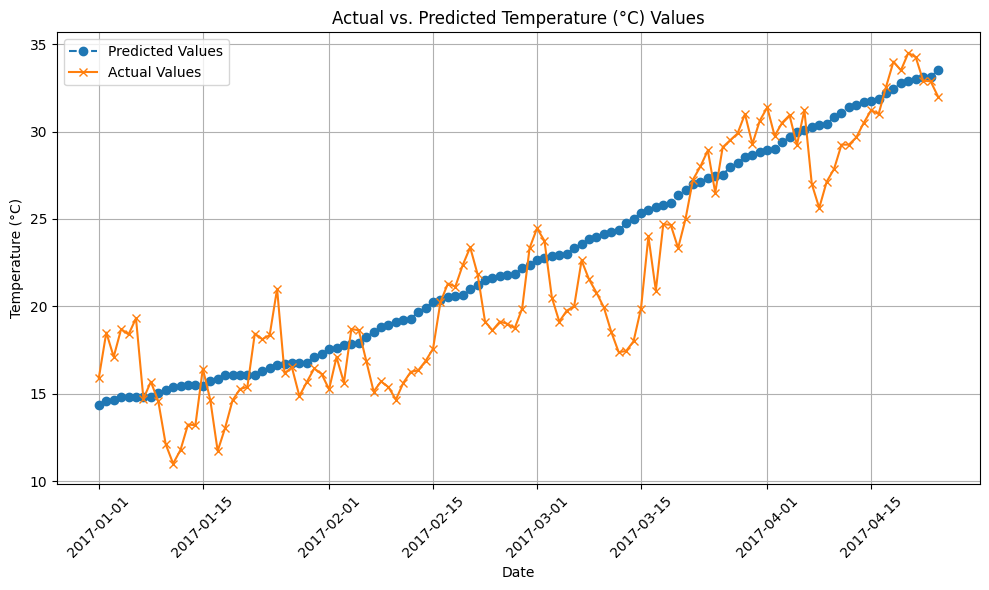

In [25]:
# Sort the DataFrame by 'Matching Dates' to ensure the data is in the correct order
result_df = result_df.sort_values(by='Matching Dates')

# Plot the predicted and actual values
plt.figure(figsize=(10, 6))
plt.plot(result_df['Matching Dates'], result_df['Predicted Values'], label='Predicted Values', linestyle='--', marker='o')
plt.plot(result_df['Matching Dates'], result_df['Actual Values'], label='Actual Values', linestyle='-', marker='x')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperature (°C) Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

- df_test has limited data for 4 months only, hence not showing seasonality

### prophet model with additional regressors

In [26]:
df

ds          y    humidity  wind_speed  meanpressure
0    2013-01-01  10.000000   84.500000    0.000000   1015.666667
1    2013-01-02   7.400000   92.000000    2.980000   1017.800000
2    2013-01-03   7.166667   87.000000    4.633333   1018.666667
3    2013-01-04   8.666667   71.333333    1.233333   1017.166667
4    2013-01-05   6.000000   86.833333    3.700000   1016.500000
...         ...        ...         ...         ...           ...
1457 2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458 2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459 2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460 2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461 2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 5 columns]

In [27]:
# split the dataset
df_train = df[df.ds <= '2016-06-01']
df_val = df[df.ds > '2016-06-01']
df_val.reset_index(drop=True, inplace=True)

In [28]:
df_train

ds          y   humidity  wind_speed  meanpressure
0    2013-01-01  10.000000  84.500000    0.000000   1015.666667
1    2013-01-02   7.400000  92.000000    2.980000   1017.800000
2    2013-01-03   7.166667  87.000000    4.633333   1018.666667
3    2013-01-04   8.666667  71.333333    1.233333   1017.166667
4    2013-01-05   6.000000  86.833333    3.700000   1016.500000
...         ...        ...        ...         ...           ...
1243 2016-05-28  36.062500  37.250000   14.405556    999.833333
1244 2016-05-29  31.500000  57.062500   11.681250   1001.250000
1245 2016-05-30  26.812500  74.812500    9.487500   1003.812500
1246 2016-05-31  32.642857  51.214286    7.407143   1002.307692
1247 2016-06-01  36.000000  42.200000    9.133333   1002.733333

[1248 rows x 5 columns]

In [29]:
df_val

ds          y    humidity  wind_speed  meanpressure
0   2016-06-02  37.562500   35.312500   11.931250   1002.000000
1   2016-06-03  37.562500   40.687500    2.781250   1002.250000
2   2016-06-04  38.200000   42.066667    3.206667   1001.866667
3   2016-06-05  36.166667   51.750000    8.500000   1002.833333
4   2016-06-06  35.428571   45.714286   11.000000   1001.571429
..         ...        ...         ...         ...           ...
209 2016-12-28  17.217391   68.043478    3.547826   1015.565217
210 2016-12-29  15.238095   87.857143    6.000000   1016.904762
211 2016-12-30  14.095238   89.666667    6.266667   1017.904762
212 2016-12-31  15.052632   87.000000    7.325000   1016.100000
213 2017-01-01  10.000000  100.000000    0.000000   1016.000000

[214 rows x 5 columns]

In [30]:
# Compute the actual values from df_val - to be used for eval later
actual_values = df_val['y'].values
actual_values

array([37.5625    , 37.5625    , 38.2       , 36.16666667, 35.42857143,
       34.625     , 36.07142857, 35.73333333, 36.13333333, 33.4375    ,
       35.5       , 36.        , 32.625     , 34.73333333, 33.5       ,
       34.1875    , 35.85714286, 35.625     , 30.9375    , 32.875     ,
       33.125     , 33.84615385, 36.4375    , 35.42857143, 34.86666667,
       34.3125    , 30.78571429, 35.375     , 35.46666667, 32.125     ,
       28.4       , 29.5625    , 30.6875    , 33.25      , 33.26666667,
       33.5       , 30.8       , 33.25      , 32.5625    , 31.5       ,
       30.5       , 31.25      , 30.4375    , 31.        , 27.125     ,
       28.125     , 27.66666667, 32.3125    , 34.1875    , 34.13333333,
       34.125     , 31.875     , 31.4375    , 31.9375    , 30.3125    ,
       28.3125    , 29.53333333, 27.375     , 27.33333333, 29.26666667,
       29.125     , 30.6875    , 32.5625    , 33.11111111, 33.8       ,
       30.06666667, 33.11764706, 33.80952381, 31.61538462, 32.  

In [31]:
df_val.drop(columns = 'y', inplace= True)

In [32]:
df_val.tail()

ds    humidity  wind_speed  meanpressure
209 2016-12-28   68.043478    3.547826   1015.565217
210 2016-12-29   87.857143    6.000000   1016.904762
211 2016-12-30   89.666667    6.266667   1017.904762
212 2016-12-31   87.000000    7.325000   1016.100000
213 2017-01-01  100.000000    0.000000   1016.000000

In [33]:
model = Prophet()
model.add_regressor('humidity')
model.add_regressor('wind_speed')
model.add_regressor('meanpressure')
model.fit(df_train)

00:36:58 - cmdstanpy - INFO - Chain [1] start processing
00:36:58 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
# Make predictions for the future dates
forecast = model.predict(df_val)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
209 2016-12-28  17.583039   15.261945   19.916422
210 2016-12-29  14.929645   12.682553   17.021002
211 2016-12-30  14.806852   12.735155   17.079644
212 2016-12-31  15.197943   12.907519   17.278819
213 2017-01-01  13.872366   11.544494   16.081039

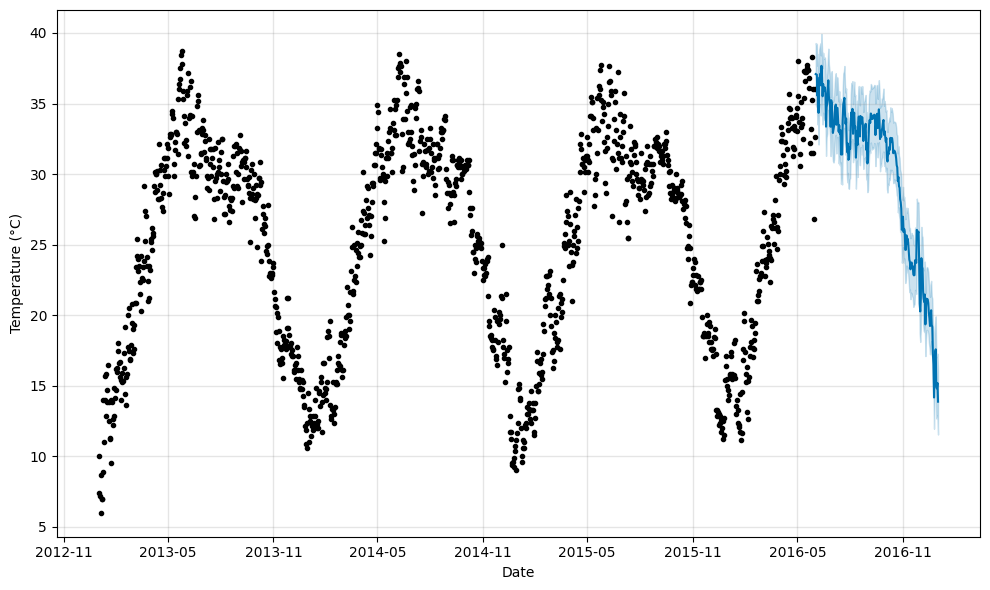

In [35]:
# Visualize the predictions
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

Mean Absolute Error (MAE): 1.8672335406724696
Mean Squared Error (MSE): 4.565357510108574
Root Mean Squared Error (RMSE): 2.136669724152185


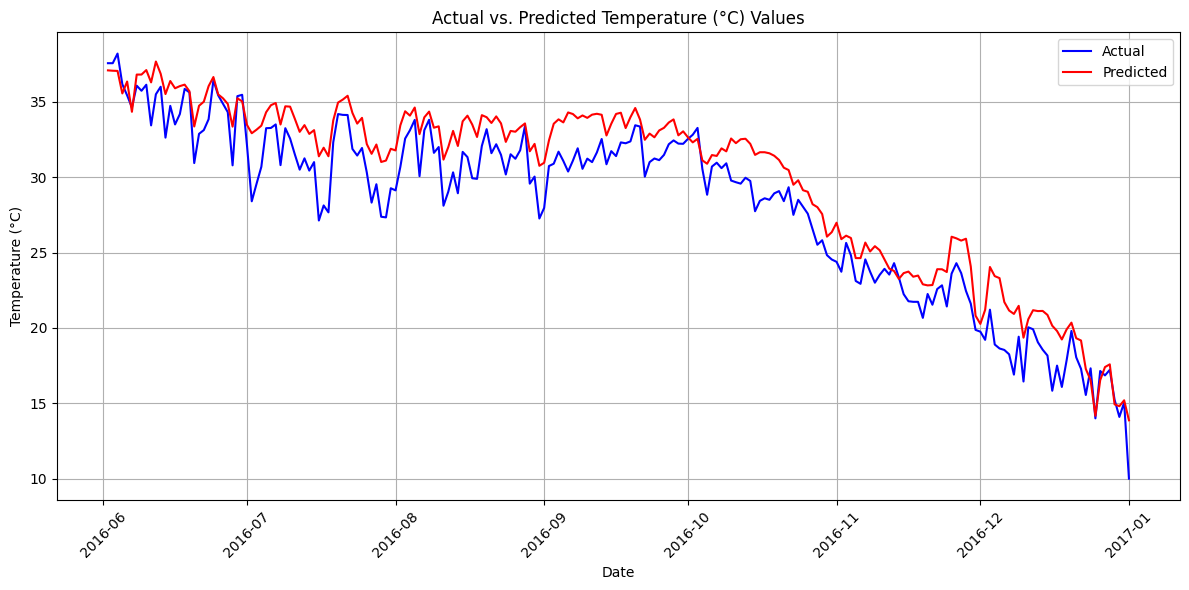

In [36]:
# Eval
# Extract the predicted values from the forecast DataFrame
predicted_values = forecast['yhat'].values

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
# rmse = np.sqrt(mse)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_val['ds'], actual_values, label='Actual', color='b')
plt.plot(df_val['ds'], predicted_values, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperature (°C) Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Out-of-Sample Forecast
- Train with full train data, Predict and Compare with test data available

In [37]:
df.shape

(1462, 5)

In [38]:
# Train model with full train data + additional regressors
model = Prophet()
model.add_regressor('humidity')
model.add_regressor('wind_speed')
model.add_regressor('meanpressure')
model.fit(df)

00:36:59 - cmdstanpy - INFO - Chain [1] start processing
00:36:59 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Compute the actual values from df_test - to be used for eval later
actual_values = df_test['y'].values
actual_values

array([15.91304348, 18.5       , 17.11111111, 18.7       , 18.38888889,
       19.31818182, 14.70833333, 15.68421053, 14.57142857, 12.11111111,
       11.        , 11.78947368, 13.23529412, 13.2       , 16.43478261,
       14.65      , 11.72222222, 13.04166667, 14.61904762, 15.26315789,
       15.39130435, 18.44      , 18.11764706, 18.34782609, 21.        ,
       16.17857143, 16.5       , 14.86363636, 15.66666667, 16.44444444,
       16.125     , 15.25      , 17.09090909, 15.63636364, 18.7       ,
       18.63157895, 16.88888889, 15.125     , 15.7       , 15.375     ,
       14.66666667, 15.625     , 16.25      , 16.33333333, 16.875     ,
       17.57142857, 20.25      , 21.3       , 21.125     , 22.36363636,
       23.375     , 21.83333333, 19.125     , 18.625     , 19.125     ,
       19.        , 18.75      , 19.875     , 23.33333333, 24.46153846,
       23.75      , 20.5       , 19.125     , 19.75      , 20.        ,
       22.625     , 21.54545455, 20.78571429, 19.9375    , 18.53

In [40]:
df_test.drop(columns = 'y', inplace= True)

In [41]:
df_test

ds   humidity  wind_speed  meanpressure
0   2017-01-01  85.869565    2.743478     59.000000
1   2017-01-02  77.222222    2.894444   1018.277778
2   2017-01-03  81.888889    4.016667   1018.333333
3   2017-01-04  70.050000    4.545000   1015.700000
4   2017-01-05  74.944444    3.300000   1014.333333
..         ...        ...         ...           ...
109 2017-04-20  27.500000    5.562500    998.625000
110 2017-04-21  39.375000    6.962500    999.875000
111 2017-04-22  40.900000    8.890000   1001.600000
112 2017-04-23  27.500000    9.962500   1002.125000
113 2017-04-24  27.142857   12.157143   1004.142857

[114 rows x 4 columns]

In [42]:
# Make predictions
forecast = model.predict(df_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
109 2017-04-20  33.656925   31.609264   35.678679
110 2017-04-21  32.323767   30.207782   34.291731
111 2017-04-22  32.272600   30.105029   34.484338
112 2017-04-23  33.898686   31.833671   36.004965
113 2017-04-24  34.066555   32.077023   36.036314

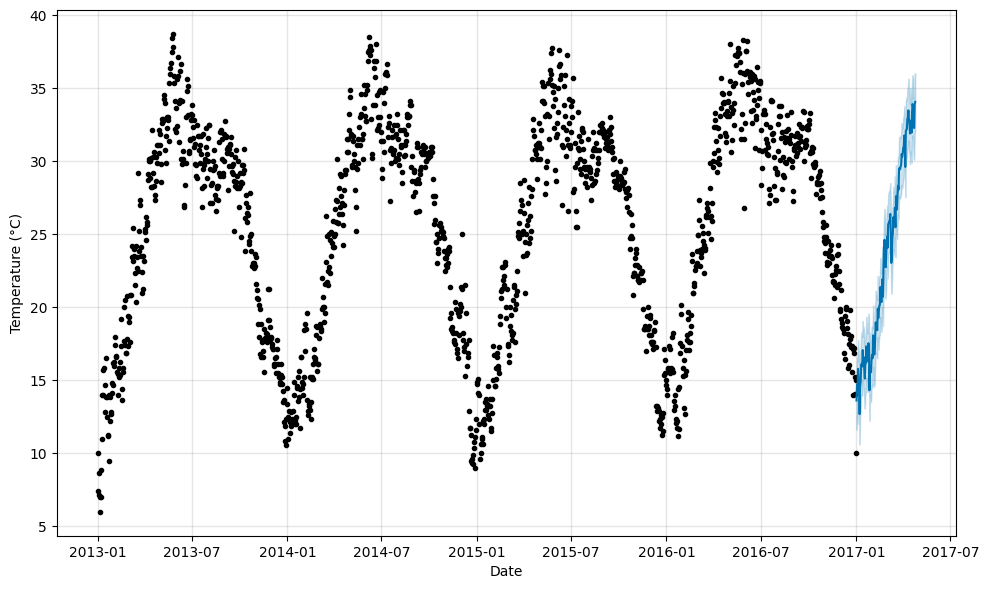

In [43]:
# Visualize the predictions
model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

Mean Absolute Error (MAE): 2.5537974356136695
Mean Squared Error (MSE): 10.398423554965769
Root Mean Squared Error (RMSE): 3.2246586726296735


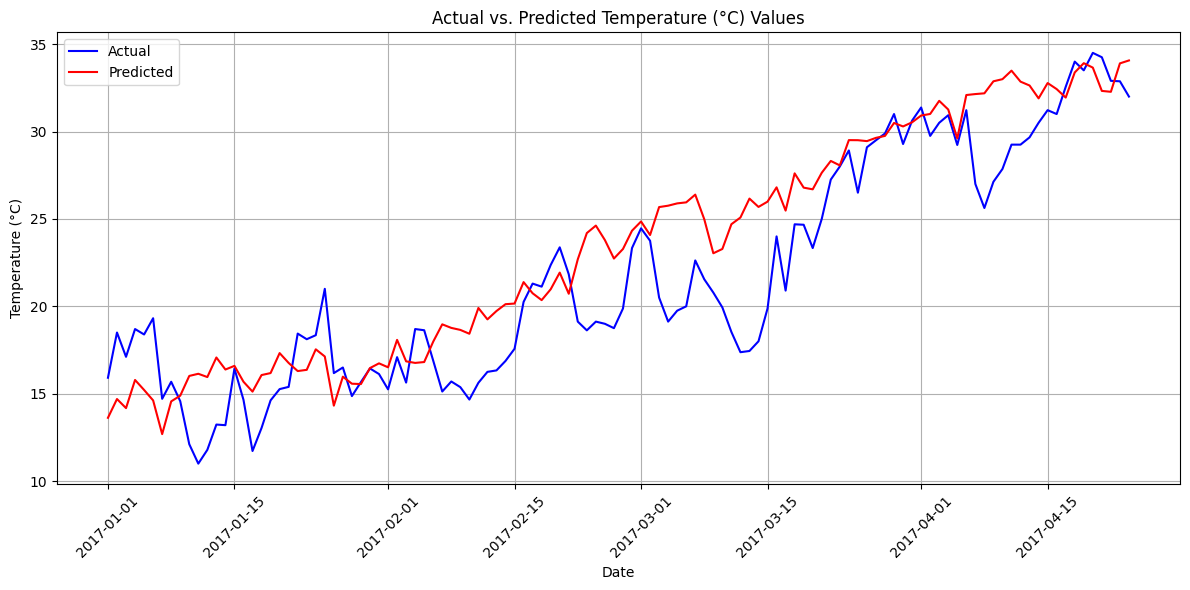

In [44]:
# Eval
# Extract the predicted values from the forecast DataFrame
predicted_values = forecast['yhat'].values

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
# rmse = np.sqrt(mse)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_test['ds'], actual_values, label='Actual', color='b')
plt.plot(df_test['ds'], predicted_values, label='Predicted', color='r')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperature (°C) Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Adding Regressors makes forecast does look sensible, at least by eye. 
- But again since test data with regressors is available for 4 months only, seasonality is not captured.

### Using model to get Temperature forecast on given date range

- Since users would normally only provide date range as input and no additional regressors, we will use `base_model` for predictions 

In [45]:
# Function to cretae date range
def create_date_range_dataframe(start_date, end_date):
    # Accept user input for start date and end date in 'YYYY-MM-DD' format
    # start_date = input("Enter start date (YYYY-MM-DD): ")
    # end_date = input("Enter end date (YYYY-MM-DD): ")

    # Convert the input strings to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Generate a list of dates between the start and end date
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create a DataFrame from the list of dates
    df = pd.DataFrame({'ds': date_range})

    return df

In [46]:
# Create date range matching with df_test: 2017-01-01 to 2019-01-01

# Specify the start and end dates
start_date = '2017-01-01'
end_date = '2019-01-01'

# Call the function to create the DataFrame
df_future = create_date_range_dataframe(start_date, end_date)

# Print the resulting DataFrame
print(df_future)

            ds
0   2017-01-01
1   2017-01-02
2   2017-01-03
3   2017-01-04
4   2017-01-05
..         ...
726 2018-12-28
727 2018-12-29
728 2018-12-30
729 2018-12-31
730 2019-01-01

[731 rows x 1 columns]


In [47]:
# Use the trained Prophet model to make predictions on the date range
forecast_future = base_model.predict(df_future)

# Print the forecasted values
print(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

            ds       yhat  yhat_lower  yhat_upper
0   2017-01-01  14.350417   11.690653   17.008808
1   2017-01-02  14.560721   12.031458   17.230661
2   2017-01-03  14.646778   12.088477   17.434316
3   2017-01-04  14.813565   12.156994   17.554368
4   2017-01-05  14.800330   11.974600   17.312378
..         ...        ...         ...         ...
726 2018-12-28  16.794031   13.586034   19.921953
727 2018-12-29  16.634566   13.385806   19.931000
728 2018-12-30  16.467874   13.474705   19.780357
729 2018-12-31  16.632346   13.504913   19.788014
730 2019-01-01  16.676884   13.574316   19.779759

[731 rows x 4 columns]


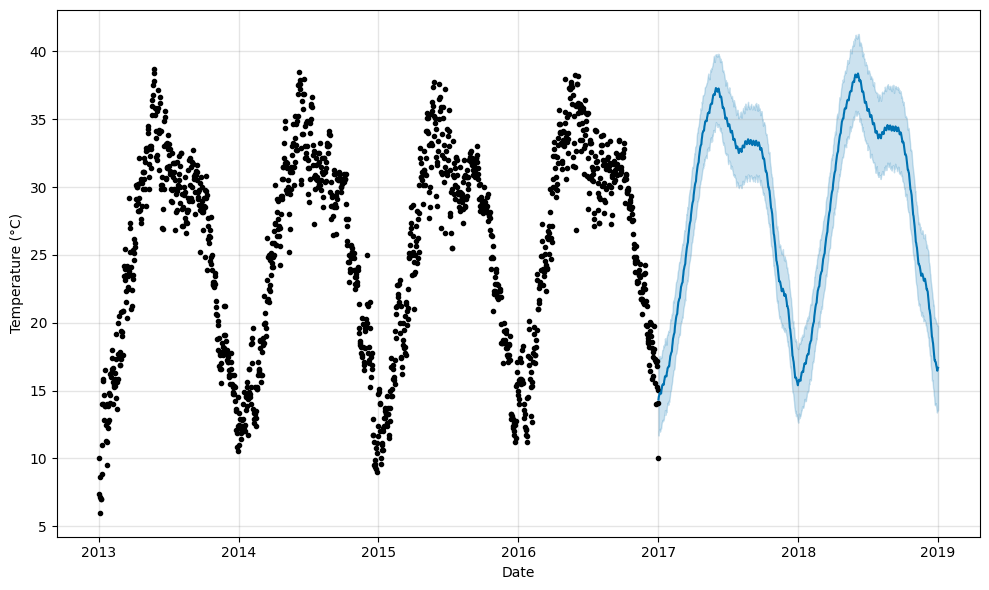

In [48]:
# Visualize the predictions
base_model.plot(forecast_future)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

### Save model

In [49]:
# Save the base_model to a file
with open("model/prophet_base_model.pkl", "wb") as model_file:
    pickle.dump(base_model, model_file)

In [50]:
# Save model with regressors to a file
with open("model/prophet_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

### Use saved model for predictions

In [51]:
# Load the saved model
with open("model/prophet_base_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

In [52]:
# Use the loaded model for forecasting
forecast_future = loaded_model.predict(df_future)
forecast_future

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-01-01  27.518657   11.619353   17.055605    27.518657    27.518657   
1   2017-01-02  27.521538   11.987782   17.244187    27.521538    27.521538   
2   2017-01-03  27.524418   12.075873   17.087920    27.524418    27.524418   
3   2017-01-04  27.527298   12.153574   17.392202    27.527298    27.527298   
4   2017-01-05  27.530179   12.224005   17.517465    27.530179    27.530179   
..         ...        ...         ...         ...          ...          ...   
726 2018-12-28  29.609780   13.923468   19.860418    28.169298    31.206310   
727 2018-12-29  29.612661   13.839851   19.659240    28.170206    31.213436   
728 2018-12-30  29.615541   13.499290   19.680788    28.171186    31.220562   
729 2018-12-31  29.618421   13.579530   19.871508    28.172225    31.227688   
730 2019-01-01  29.621302   13.699034   19.723416    28.173428    31.234814   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        -13.168240            -13.168240            -13.168240 -0.195063   
1        -12.960817            -12.960817            -12.960817 -0.010773   
2        -12.877640            -12.877640            -12.877640  0.034028   
3        -12.713733            -12.713733            -12.713733  0.146257   
4        -12.729848            -12.729848            -12.729848  0.067150   
..              ...                   ...                   ...       ...   
726      -12.815750            -12.815750            -12.815750  0.027528   
727      -12.978095            -12.978095            -12.978095 -0.069127   
728      -13.147667            -13.147667            -13.147667 -0.195063   
729      -12.986076            -12.986076            -12.986076 -0.010773   
730      -12.944418            -12.944418            -12.944418  0.034028   

     weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0       -0.195063     -0.195063 -12.973177    -12.973177    -12.973177   
1       -0.010773     -0.010773 -12.950044    -12.950044    -12.950044   
2        0.034028      0.034028 -12.911668    -12.911668    -12.911668   
3        0.146257      0.146257 -12.859990    -12.859990    -12.859990   
4        0.067150      0.067150 -12.796998    -12.796998    -12.796998   
..            ...           ...        ...           ...           ...   
726      0.027528      0.027528 -12.843277    -12.843277    -12.843277   
727     -0.069127     -0.069127 -12.908969    -12.908969    -12.908969   
728     -0.195063     -0.195063 -12.952604    -12.952604    -12.952604   
729     -0.010773     -0.010773 -12.975303    -12.975303    -12.975303   
730      0.034028      0.034028 -12.978446    -12.978446    -12.978446   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
726                   0.0                         0.0   
727                   0.0                         0.0   
728                   0.0                         0.0   
729                   0.0                         0.0   
730                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
0                           0.0  14.350417  
1                           0.0  14.560721  
2                           0.0  14.646778  
3                           0.0  14.813565  
4                           0.0  14.800330  
..                          ...        ...  
726                         0.0  16.794031  
727                         0.0  16.634566  
728                         0.0  16.467874  
729                         0.0  16.632346  
730                         0.0  16.676884  

[731 rows x 19 columns]

In [53]:
# Print the forecasted values of interest
print(forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

            ds       yhat  yhat_lower  yhat_upper
0   2017-01-01  14.350417   11.619353   17.055605
1   2017-01-02  14.560721   11.987782   17.244187
2   2017-01-03  14.646778   12.075873   17.087920
3   2017-01-04  14.813565   12.153574   17.392202
4   2017-01-05  14.800330   12.224005   17.517465
..         ...        ...         ...         ...
726 2018-12-28  16.794031   13.923468   19.860418
727 2018-12-29  16.634566   13.839851   19.659240
728 2018-12-30  16.467874   13.499290   19.680788
729 2018-12-31  16.632346   13.579530   19.871508
730 2019-01-01  16.676884   13.699034   19.723416

[731 rows x 4 columns]


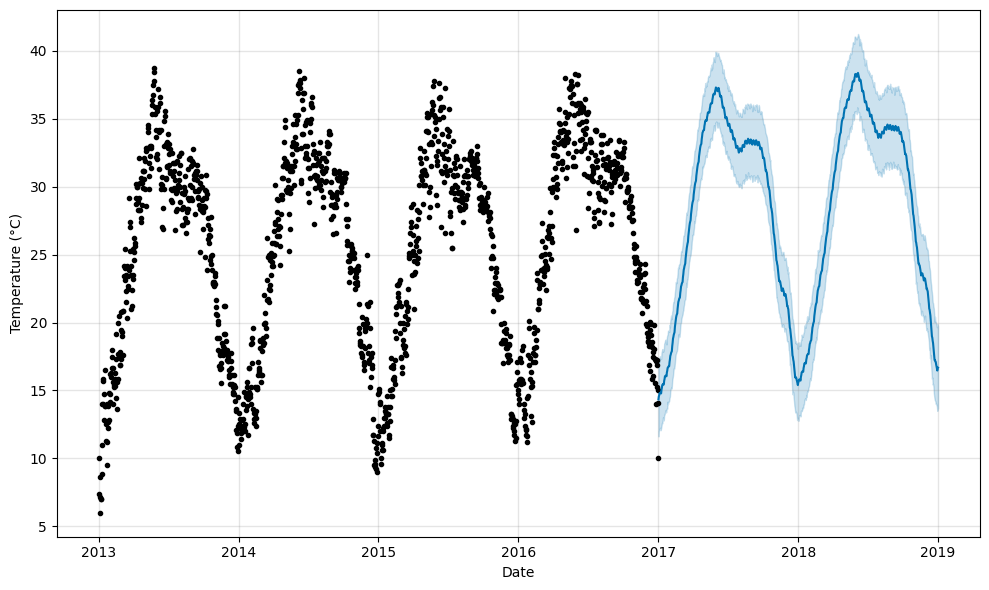

In [54]:
# Visualize the predictions
loaded_model.plot(forecast_future)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()